In [1]:
import warnings

In [2]:
warnings.filterwarnings('ignore')

✅Start by importing all the necessary libraries and modules.

In [3]:
import numpy as np
import pandas as pd
import shap as sh

from scipy.stats import shapiro, normaltest

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from catboost import Pool

from sklearn.model_selection import train_test_split

from sklearn.metrics import root_mean_squared_error

✅Perform some EDA and handle missing values.

In [4]:
data = pd.read_csv('train.csv')

In [5]:
data.shape

(1460, 81)

In [6]:
data.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [7]:
data.drop(['Id'], axis=1, inplace=True)

In [8]:
data.isna().any().any()

True

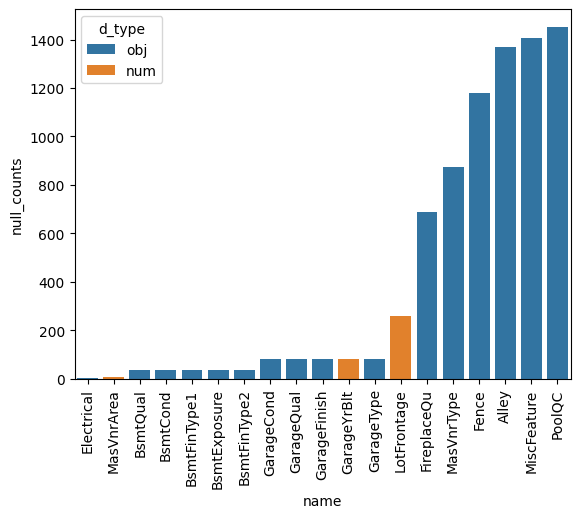

In [9]:
nulls = {'name': [], 'null_counts': [], 'd_type': []}

for column in data.columns:
    if data[column].isna().any():
        nulls['name'].append(column)
        nulls['null_counts'].append(data[column].isna().sum())
        nulls['d_type'].append('obj' if column in data.select_dtypes('object').columns else 'num')

nulls = pd.DataFrame(nulls)
nulls.sort_values(by=['null_counts'], inplace=True)
sns.barplot(x=nulls['name'], y=nulls['null_counts'], hue=nulls['d_type'])
plt.xticks(rotation=90)
plt.show()

In [10]:
nulls_to_drop = [column for column in nulls['name'] if column in list(nulls.where(nulls['null_counts'] > 400)['name'])]
nulls_to_drop

['FireplaceQu', 'MasVnrType', 'Fence', 'Alley', 'MiscFeature', 'PoolQC']

In [11]:
data.drop(nulls_to_drop, axis=1, inplace=True)

In [12]:
nulls_num = [column for column in nulls['name'] 
                if column in list(nulls.where(nulls['d_type'] == 'num')['name']) and
                column not in nulls_to_drop]
nulls_obj = [column for column in nulls['name']
                if column in list(nulls.where(nulls['d_type'] == 'obj')['name']) and
                column not in nulls_to_drop]

for column in nulls_num:
    data[column].fillna(value=data[column].median(), inplace=True)

for column in nulls_obj:
    data[column].fillna(value=data[column].mode()[0], inplace=True)

In [13]:
data.isna().any().any()

False

✅Observe the target and its dissemination.

In [14]:
target = data['SalePrice']
data.drop(['SalePrice'], axis=1, inplace=True)

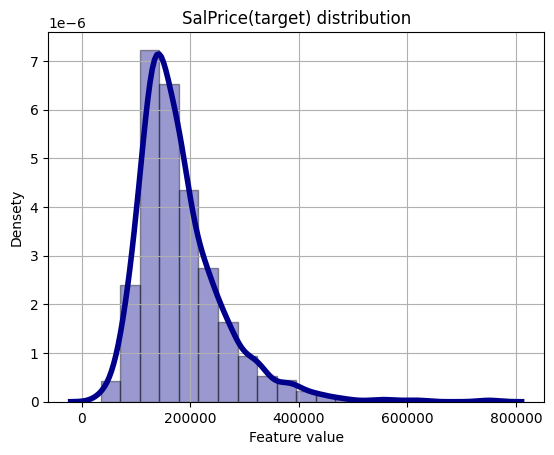

In [15]:
sns.distplot(target, hist=True, kde=True,
             bins=20, color='darkblue',
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
plt.xlabel('Feature value')
plt.ylabel('Densety')
plt.title('SalPrice(target) distribution')
plt.grid(True)
plt.show()

✅Verify the assumptions about the normal distribution based on a few standards.

In [16]:
# do Shapiro-Wilk test
statistic, pvalue = shapiro(target)
print(f'Statistic: {statistic:.3f}, p-value: {pvalue:.3f}')

Statistic: 0.870, p-value: 0.000


In [17]:
# do Kolmogorov-Smirnov test
statistic, pvalue = normaltest(target)
print(f'Statistic: {statistic:.3f}, p-value: {pvalue:.3f}')

Statistic: 610.836, p-value: 0.000


✅So yes, it is not normal distribution(p-value < 0.05)

✅Build dummy and boosting models.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=30)

In [19]:
# baseline model - dummy regressor
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
print('Dummy RMSE: ', root_mean_squared_error(y_test, dummy.predict(X_test)))
print('Dummy R2-score: ', dummy.score(X_test, y_test))

Dummy RMSE:  86005.13916414435
Dummy R2-score:  -0.004601382961449518


In [20]:
# gradient boosting via yandex catboost
cat_features = data.select_dtypes('object').columns.to_list()

train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_features,
    feature_names=list(X_train.columns)
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_features,
    feature_names=list(X_test.columns)
)

boosting = CatBoostRegressor(verbose=100,
                            eval_metric='RMSE',
                            iterations=5000,
                            learning_rate=0.02,
                            depth=5,
                            l2_leaf_reg=5
                            )
boosting.fit(train_pool)

0:	learn: 75512.2298818	total: 56.9ms	remaining: 4m 44s
100:	learn: 33995.8369136	total: 781ms	remaining: 37.9s
200:	learn: 24776.7317392	total: 1.52s	remaining: 36.3s
300:	learn: 21423.9714324	total: 2.22s	remaining: 34.7s
400:	learn: 19663.2614203	total: 2.94s	remaining: 33.7s
500:	learn: 18425.4069438	total: 3.67s	remaining: 33s
600:	learn: 17622.5380298	total: 4.43s	remaining: 32.4s
700:	learn: 16966.9379235	total: 5.18s	remaining: 31.8s
800:	learn: 16392.0908691	total: 5.93s	remaining: 31.1s
900:	learn: 15785.3069362	total: 6.73s	remaining: 30.6s
1000:	learn: 15330.9742554	total: 7.5s	remaining: 30s
1100:	learn: 14821.0483308	total: 8.26s	remaining: 29.3s
1200:	learn: 14301.8798979	total: 9.03s	remaining: 28.6s
1300:	learn: 13804.9596282	total: 9.79s	remaining: 27.8s
1400:	learn: 13327.6451898	total: 10.6s	remaining: 27.2s
1500:	learn: 12994.1515376	total: 11.4s	remaining: 26.5s
1600:	learn: 12640.1358929	total: 12.1s	remaining: 25.8s
1700:	learn: 12252.0436079	total: 12.9s	remain

In [21]:
print('Boosting RMSE: ', root_mean_squared_error(y_test, boosting.predict(X_test)))
print('Boosting R2-score: ', boosting.score(X_test, y_test))

Boosting RMSE:  27437.645848909717
Boosting R2-score:  0.897755805422724


✅Explore boosting results using Shapley values.

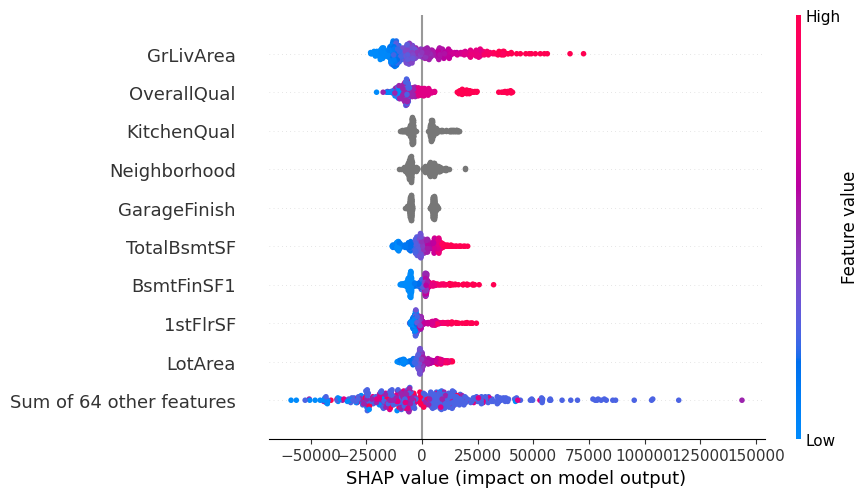

In [22]:
# explain the boosting model with SHAP
explainer_ebm = sh.TreeExplainer(boosting, feature_perturbation='tree_path_dependent')
shap_values_ebm = explainer_ebm(X_test)
sh.plots.beeswarm(shap_values_ebm)

✅The following features determine the output of the model well:<br>
<ul>
    <li>GrLivArea</li>
    <li>OverallQual</li>
    <li>TotalBsmtSF</li>
</ul>

✅Look on expecting model output(from 'GrLivArea'):

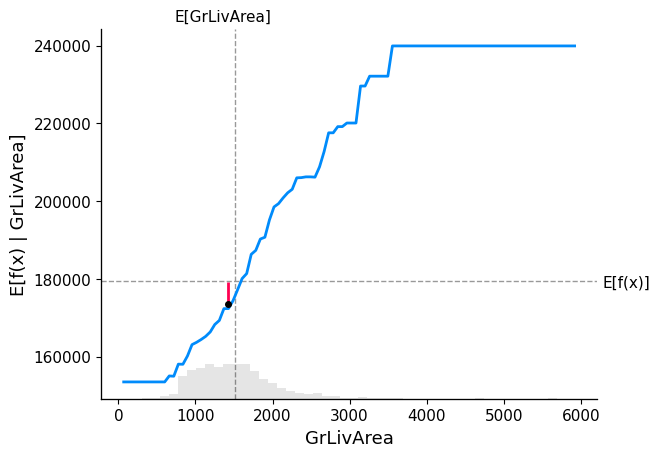

In [23]:
fig, ax = sh.partial_dependence_plot(
    'GrLivArea',
    boosting.predict,
    X_train,
    model_expected_value=True,
    feature_expected_value=True,
    show=False,
    ice=False,
    shap_values=shap_values_ebm[20 : 21, :],
)

Few words about graphic legend:<br>
<ul>
    <li>E[GrLivArea] - median feature('GrLivArea') value</li>
    <li>E[f(x)] - expecting model output</li>
    <li>Grey histogram - feature distribution</li>
</ul>

✅See on shap scatter:

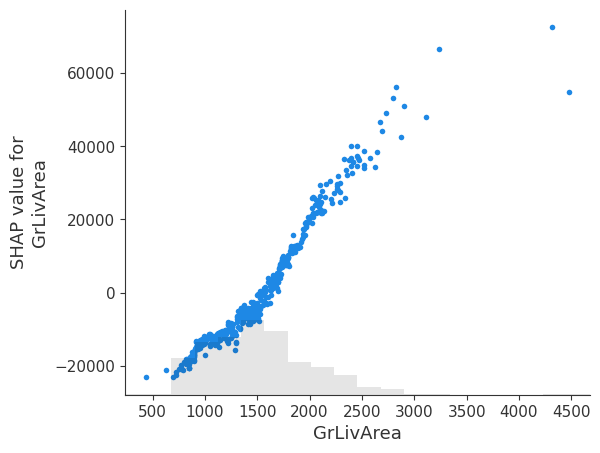

In [24]:
sh.plots.scatter(shap_values_ebm[:, 'GrLivArea'])

✅Let's find out what contribution the features made to the prediction for one object:

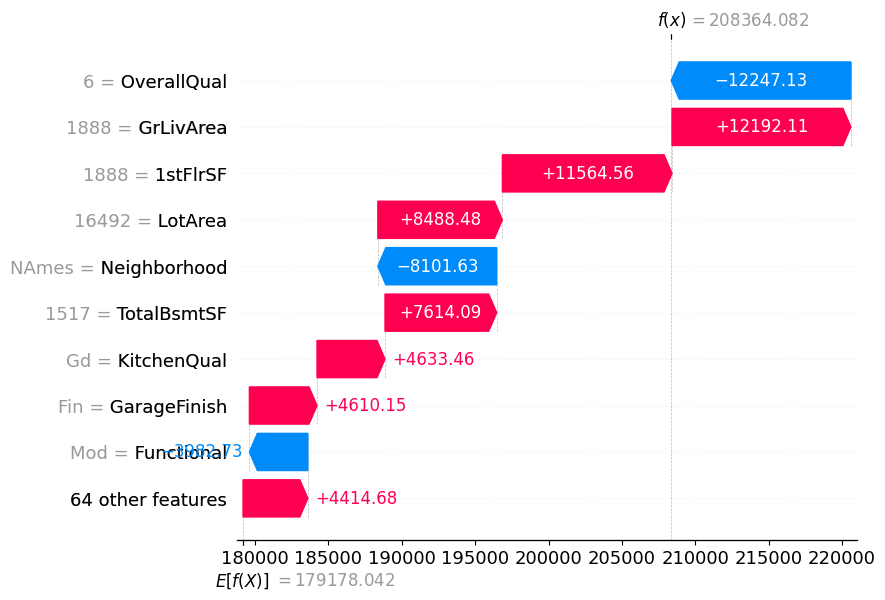

In [25]:
sh.plots.waterfall(shap_values_ebm[25])

✅And finally see on all features weights:

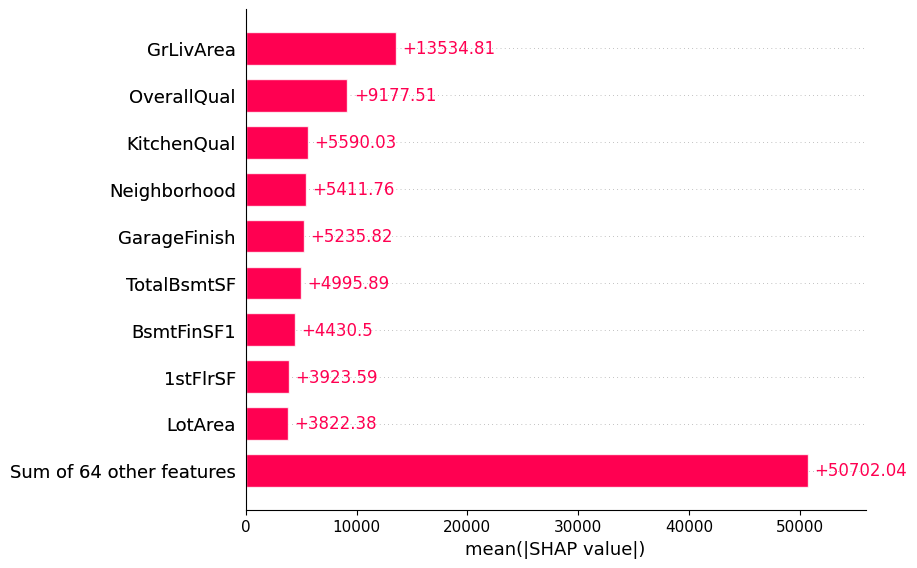

In [26]:
sh.plots.bar(shap_values_ebm)